# Aim of this project 

Write an abstract
Solubility of small organic molecules in drug desing is very important.
Solubility plays a critical role in
Experimental definition of solublity is a quite expensive procedure.
It will very valuable to have a predictive model that could estimate the solubility of drug-like molecules.
The aim of this project is to test different predictive models and chemical fingerprints in estimating the solublity of small like molecules.

----

### What is solubility? What is logP?

In [2]:
# RDKit packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors


# RDKit descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP 
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation

#from xgboost import XGBClassifier
#import lightgbm as lgbm

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/btatsis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#Read solubility data
sol_data = pd.read_csv('datasets/huuskonsen_data.csv')
print(sol_data.head(n=3))

def estate_fingerprint_and_mw(mol):
    return np.append(FingerprintMol(mol)[0], Descriptors.MolWt(x))

#Add some new columns
sol_data['ROMol'] = sol_data['smiles'].apply(Chem.MolFromSmiles)
print("The Huuskonsen data set contains ", len(sol_data), " compounds")

# Adding a few more descriptors (MW, HAC, RingCount, and TPSA)
# Althought, in this project we will use only the structural fingerprints 
# to calculate a small molecule's logp
sol_data['MW']             = sol_data['ROMol'].map(Descriptors.MolWt)
sol_data['HeavyAtomCount'] = sol_data['ROMol'].map(Descriptors.HeavyAtomCount)
sol_data['RingCount']      = sol_data['ROMol'].map(Descriptors.RingCount)
sol_data['TPSA']           = sol_data['ROMol'].map(Descriptors.TPSA)

# Add Chemical structure to Pandas frame
PandasTools.AddMoleculeColumnToFrame(sol_data,smilesCol='smiles',molCol='ROMol',includeFingerprints=True)

# Target values
y = sol_data['solubility'].values

                 smiles  solubility  logp
0  c1ccccc1c2cc(Cl)ccc2       -4.88  4.40
1  O=N(=O)c(c(ccc1)C)c1       -2.33  2.36
2          CC(O)CCC(C)C       -1.38  2.17
The Huuskonsen data set contains  1297  compounds


----
1297 small organic compounds can be found in the Huuskonsen data set.  
Let's __visualize__ the _chemical space_ of the compounds found in the training dataset!

In [5]:
print(sol_data.describe())

        solubility         logp           MW  HeavyAtomCount    RingCount         TPSA
count  1297.000000  1297.000000  1297.000000     1297.000000  1297.000000  1297.000000
mean     -2.751434     2.443724   199.453295       13.045490     1.382421    36.640486
std       2.040823     2.036324    94.710410        6.299392     1.269393    34.777512
min     -11.620000    -8.780000    17.031000        1.000000     0.000000     0.000000
25%      -3.960000     1.280000   122.189000        8.000000     0.000000     9.230000
50%      -2.510000     2.340000   178.220000       12.000000     1.000000    29.100000
75%      -1.380000     3.590000   260.676000       17.000000     2.000000    52.930000
max       1.580000    10.200000   665.733000       47.000000     7.000000   331.940000


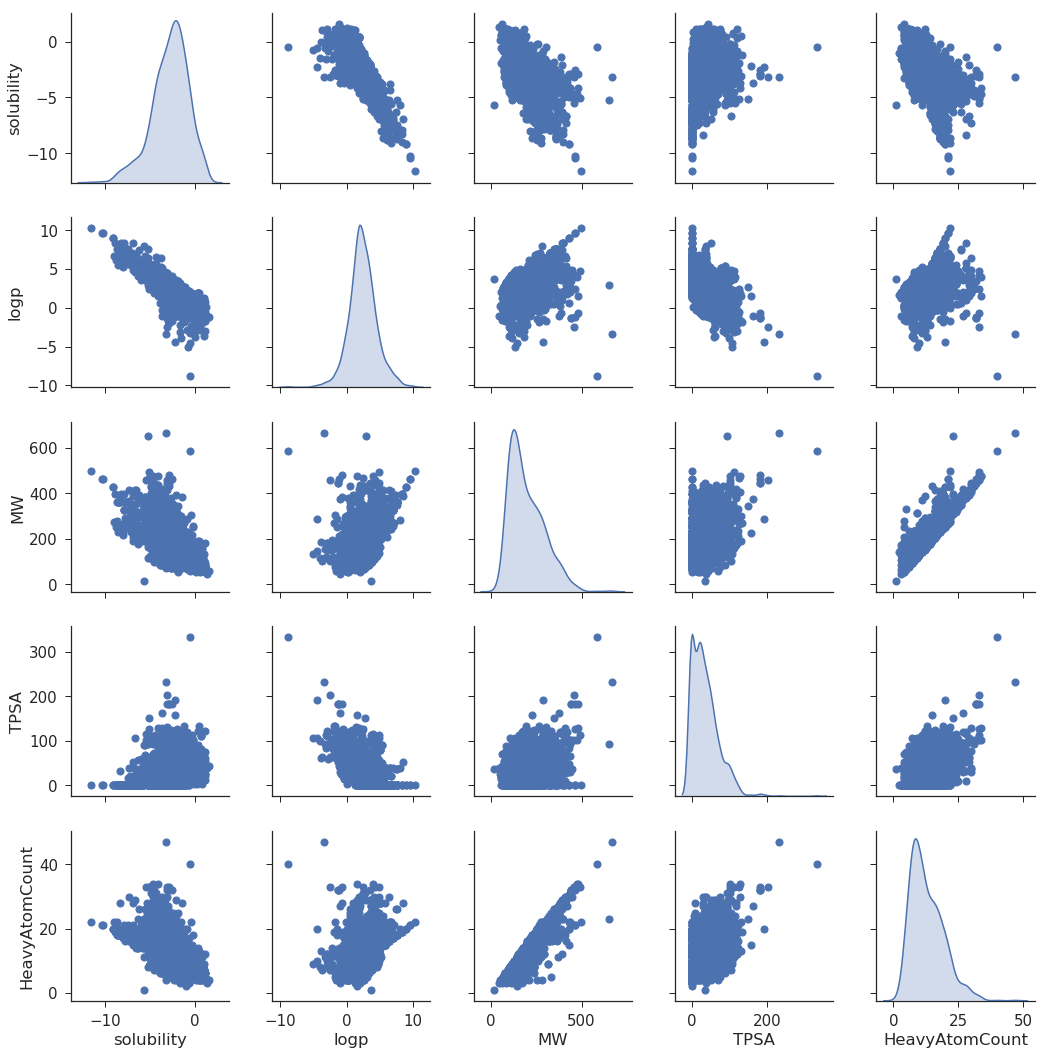

In [11]:
# seaborn -- for better looking plots
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.set_context("talk", rc={"lines.linewidth": 2})
sns.color_palette("pastel")

g = sns.pairplot(sol_data[['solubility', 'logp', 'MW', 'TPSA', 'HeavyAtomCount']], size=3, diag_kind="kde", markers="o",
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(shade=True))

### Training dataset's description

The training dataset contains 1297 organic molecules having on average two rings and MW around 200. From the average value of Polar Surface Area (TPSA) we can infer that in the training dataset there are not many compounds with heteroatoms (N,O,S,P).

----

From the plot and the data summary, displayed above, we notice that there are a few compounds with high MW (MW~600) and high Polar Surface Area (TPSA > 100).
I would like to highlight these compounds and then it will be interesting to check how the models's behaviour on these compounds.

There are 15 compounds with high MW and TPSA values!


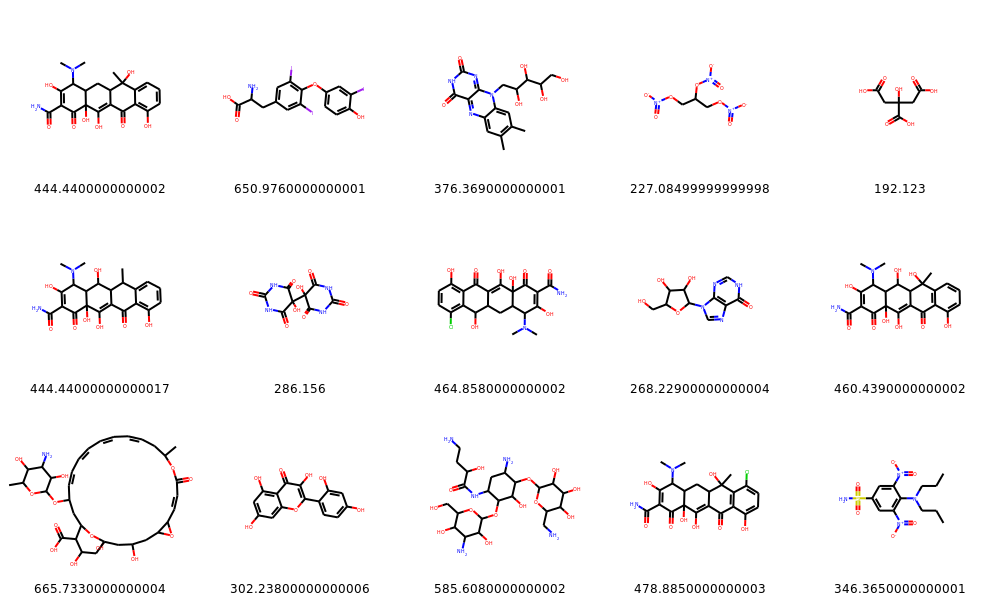

In [6]:
highMW =  sol_data[(sol_data['MW'] > 500) | (sol_data['TPSA'] > 130)]
#highMW.head()
print("There are", len(highMW), "compounds with high MW and TPSA values!")
PandasTools.FrameToGridImage(highMW,molsPerRow=5, legendsCol='MW')

There are indeed some very "interesting" compounds in this dataset.   
It would be interesting to see if the ML models could predict accurately the solubility values of these 15 compounds.

### Let's make some (chemical) fingerprints!
#### Discussion about fingerprints...

In [12]:
# Function
def ExplicitBitVect_to_NumpyArray(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

class fingerprint():
    def __init__(self, fp_fun, name):
        self.fp_fun = fp_fun
        self.name = name
        self.x = []

    def apply_fp(self, mols):
        for mol in mols:
            fp = self.fp_fun(mol)
            if isinstance(fp, tuple):
                fp = np.array(list(fp[0]))
            if isinstance(fp, rdkit.DataStructs.cDataStructs.ExplicitBitVect):
                fp = ExplicitBitVect_to_NumpyArray(fp)
            if isinstance(fp,rdkit.DataStructs.cDataStructs.IntSparseIntVect):
                fp = np.array(list(fp))

            self.x += [fp]
            
def make_fingerprints(length = 1024, verbose=True):
    fp_list = [
         fingerprint(lambda x : GetHashedAtomPairFingerprintAsBitVect(x, nBits = length),
                     "Atom pair (1985)"),
         fingerprint(lambda x : GetHashedTopologicalTorsionFingerprintAsBitVect(x, nBits = length),
                     "Topological torsion (1987)"),
         fingerprint(lambda x : GetMorganFingerprintAsBitVect(x, 2, nBits = length),
                     "Morgan circular "),
         fingerprint(FingerprintMol, "Estate (1995)"),
         fingerprint(lambda x: GetAvalonFP(x, nBits=length),
                    "Avalon bit based (2006)"),
         fingerprint(lambda x: np.append(GetAvalonFP(x, nBits=length), Descriptors.MolWt(x)),
                    "Avalon+mol. weight"),
         fingerprint(lambda x: GetErGFingerprint(x), "ErG fingerprint (2006)"),
         fingerprint(lambda x : RDKFingerprint(x, fpSize=length),
                     "RDKit fingerprint")
    ]

    for fp in fp_list:
        if (verbose): print("Converting...", fp.name)
        fp.apply_fp(list(sol_data['ROMol']))

    return fp_list

print(fp_list)
fp_list = make_fingerprints()
print()

[<__main__.fingerprint object at 0x7f540d05c240>, <__main__.fingerprint object at 0x7f540d05c208>, <__main__.fingerprint object at 0x7f540d05c2e8>, <__main__.fingerprint object at 0x7f540d05c2b0>, <__main__.fingerprint object at 0x7f540d05c438>, <__main__.fingerprint object at 0x7f540d05c320>, <__main__.fingerprint object at 0x7f540d05c588>, <__main__.fingerprint object at 0x7f540d05c748>]
Converting... Atom pair (1985)
Converting... Topological torsion (1987)
Converting... Morgan circular 
Converting... Estate (1995)
Converting... Avalon bit based (2006)
Converting... Avalon+mol. weight
Converting... ErG fingerprint (2006)
Converting... RDKit fingerprint


In [15]:
def test_model_cv(model, x, y, cv=10):
    scores = cross_validation.cross_val_score(model, x, y, cv=cv, n_jobs=-1, 
                                            scoring='neg_mean_absolute_error')

    scores = -1*scores

    return scores.mean()


def test_fingerprints(fp_list, model, y, verbose = True):

    fingerprint_scores = {}

    for fp in fp_list:
        if verbose: print("Generating ", fp.name, "fingerprints")
        fingerprint_scores[fp.name] = test_model_cv(model, fp.x, y)

    sorted_names = sorted(fingerprint_scores, key=fingerprint_scores.__getitem__, reverse=False)

    #print("\n Using Linear Regression Model: ", model)
    print("          ----------------------------------")
    print("                name        CV avg abs error")
    print("          ----------------------------------")
    for i in range(len(sorted_names)):
        name = sorted_names[i]
        print("%26s    %5.3f " % (name, fingerprint_scores[name]))
    print("          ----------------------------------")

# Tikhonov estimation
test_fingerprints(fp_list, BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-03, alpha_2=1e-03, lambda_1=1e-03, lambda_2=1e-03), y, verbose=True)
test_fingerprints(fp_list, Ridge(alpha=1e-3), y, verbose=True)

Generating  Atom pair (1985) fingerprints
Generating  Topological torsion (1987) fingerprints
Generating  Morgan circular  fingerprints
Generating  Estate (1995) fingerprints
Generating  Avalon bit based (2006) fingerprints
Generating  Avalon+mol. weight fingerprints
Generating  ErG fingerprint (2006) fingerprints
Generating  RDKit fingerprint fingerprints
          ----------------------------------
                name        CV avg abs error
          ----------------------------------
        Avalon+mol. weight    0.613 
             Estate (1995)    0.675 
   Avalon bit based (2006)    0.765 
         RDKit fingerprint    0.780 
          Atom pair (1985)    0.796 
          Morgan circular     0.859 
Topological torsion (1987)    0.864 
    ErG fingerprint (2006)    1.281 
          ----------------------------------
Generating  Atom pair (1985) fingerprints
Generating  Topological torsion (1987) fingerprints
Generating  Morgan circular  fingerprints
Generating  Estate (1995) fin

Estate fingerprints are highly ranked in both Ridge regression and Bayesian Ridge regression.  
Fingerprints encode chemical information into a series of zeros and ones, hence I thought to use also the Bayesian Ridge regression to study the influnece of the selected fingerprints contribution to the model.   
Estate fingerprints will be used for training the machine learning models.

In [16]:
def estate_fingerprint(mol):
    return FingerprintMol(mol)[0]

#Scale X to unit variance and zero mean
sol_data['Fingerprint'] = sol_data['ROMol'].apply(estate_fingerprint)

X = np.array(list(sol_data['Fingerprint']))

st = StandardScaler()
X = np.array(list(sol_data['Fingerprint']))
X = st.fit_transform(X)

/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/btatsis/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Machine Learning models

In [115]:
KRmodel = GridSearchCV(KernelRidge(), cv=10,
                       param_grid={"alpha": np.logspace(-10, -5, 10),
                       "gamma": np.logspace(-12, -9, 10), "kernel" : ['laplacian', 'rbf']}, scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel = KRmodel.fit(X, y)
Best_KernelRidge = KRmodel.best_estimator_

print("Best Kernel Ridge model")
print(KRmodel.best_params_)
print('Best score for Kernel Ridge model: '-1*KRmodel.best_score_)

Best Kernel Ridge model
{'alpha': 1e-10, 'gamma': 2.1544346900318868e-11, 'kernel': 'laplacian'}


TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U35') dtype('<U35') dtype('<U35')

In [11]:
Rmodel = GridSearchCV(Ridge(), cv=20,
                      param_grid={"alpha": np.logspace(-10, -5, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)

Rmodel = Rmodel.fit(X, y)
Best_Ridge = Rmodel.best_estimator_

print("Best Ridge model")
print(Rmodel.best_params_)
print(-1*Rmodel.best_score_)

Best Ridge model
{'alpha': 1e-10}
0.6665733159634711


In [19]:
GPmodel = GridSearchCV(GaussianProcessRegressor(normalize_y=True), cv=20,
                       param_grid={"alpha": np.logspace(-15, -10, 30),}, scoring='neg_mean_absolute_error', n_jobs=-1)

GPmodel = GPmodel.fit(X, y)
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print(GPmodel.best_params_)
print(-1*GPmodel.best_score_)

Best Gaussian Process model
{'alpha': 1.7433288221999874e-13}
0.8101841710228215


In [18]:
RFmodel = GridSearchCV(RandomForestRegressor(), cv=20,
                       param_grid={"n_estimators": np.linspace(50, 150, 25).astype('int')}, scoring='neg_mean_absolute_error', n_jobs=-1)

RFmodel = RFmodel.fit(X, y)
Best_RandomForestRegressor = RFmodel.best_estimator_

print("Best Random Forest model")
print(RFmodel.best_params_)
print(-1*RFmodel.best_score_)

Best Random Forest model
{'n_estimators': 137}
0.608655349019697


<Figure size 432x288 with 0 Axes>

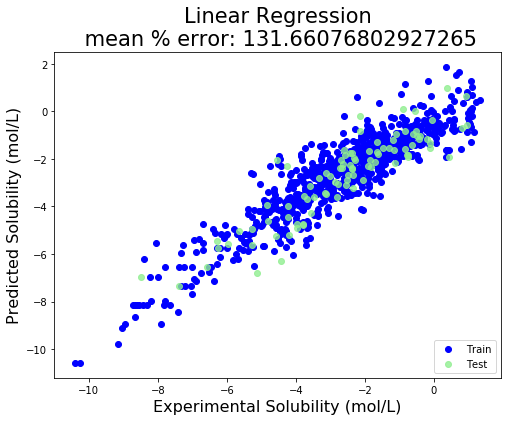

<Figure size 432x288 with 0 Axes>

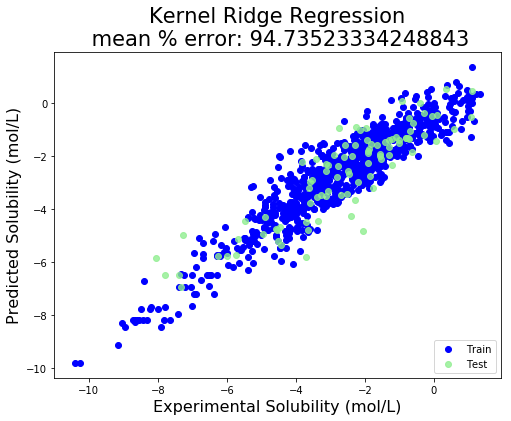

<Figure size 432x288 with 0 Axes>

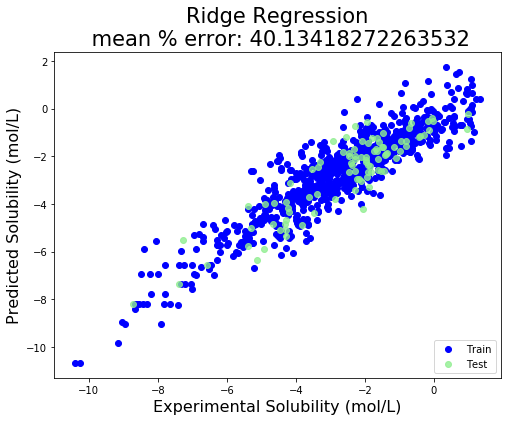

<Figure size 432x288 with 0 Axes>

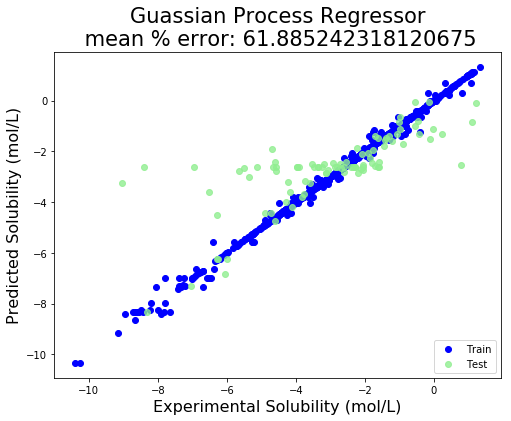

<Figure size 432x288 with 0 Axes>

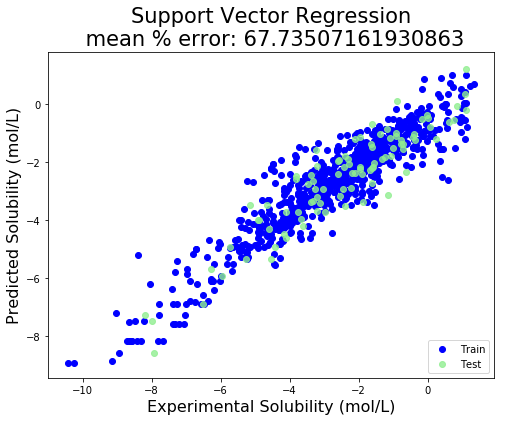

<Figure size 432x288 with 0 Axes>

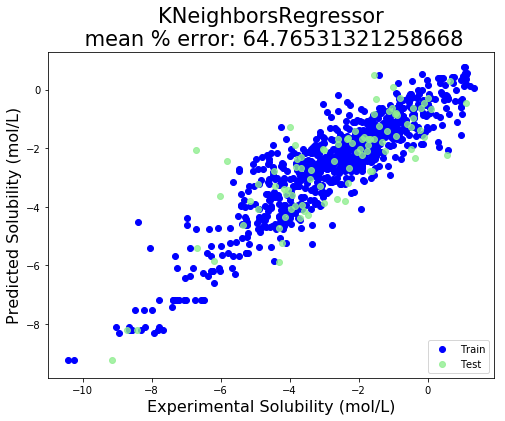

<Figure size 432x288 with 0 Axes>

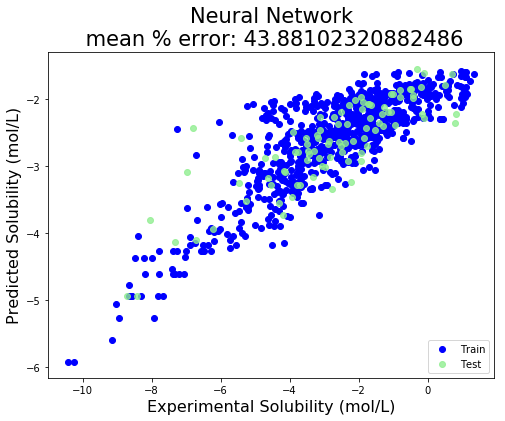

<Figure size 432x288 with 0 Axes>

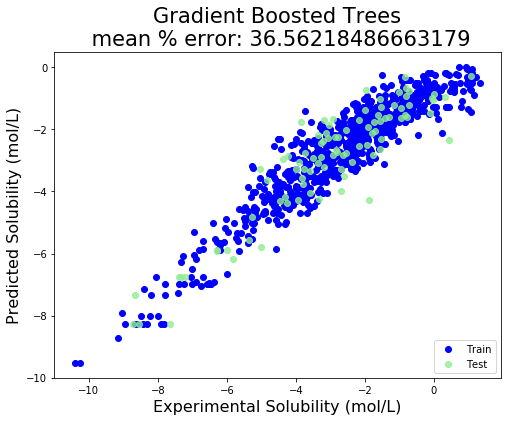

<Figure size 432x288 with 0 Axes>

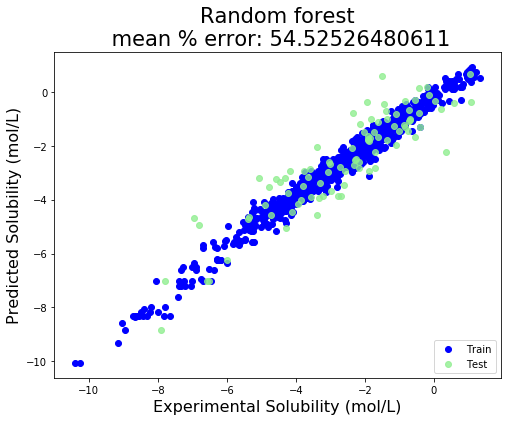

\begin{tabular}{c c c}
           name     &      % test err   & .    abs error in CV \\ 
\hline
                 Random forest & 54.525 & 0.612 \\
     Support Vector Regression & 67.735 & 0.634 \\
       Kernel Ridge Regression & 94.735 & 0.662 \\
              Ridge Regression & 40.134 & 0.667 \\
        Gradient Boosted Trees & 36.562 & 0.706 \\
           KNeighborsRegressor & 64.765 & 0.803 \\
    Guassian Process Regressor & 61.885 & 0.810 \\
                Neural Network & 43.881 & 0.912 \\
             Linear Regression & 131.661 & 1297292695479.473 \\
\end{tabular}


In [20]:
#import pickle
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.metrics.pairwise import rbf_kernel

def make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, title='', figsize=(6,4), fontsize=16):    
    plt.clf()
    plt.figure(figsize=figsize)
    plt.scatter(y_train,y_pred_train, label = 'Train', c='blue')
    plt.title(title,fontsize=fontsize+5)
    plt.xlabel('Experimental Solubility (mol/L)', fontsize=fontsize)
    plt.ylabel('Predicted Solubility (mol/L)', fontsize=fontsize)
    plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8)
    plt.legend(loc=4)
    plt.show()

def test_models_and_plot(x, y, model_dict, plots=True):
    ''' test a bunch of models and print out a sorted list of CV accuracies
        inputs: 
            x: training data features, numpy array or Pandas dataframe
            y: training data labels, numpy array or Pandas dataframe
            model_dict: a dictionary of the form {name : model()}, where 'name' is a string
                        and 'model()' is a sci-kit-learn model object. 
    '''

    mean_scores = {}
    percent_errors = {}

    for (name, model) in model_dict.items():
        #print("running %s" % name)
        scores = cross_validation.cross_val_score(model, x, y, cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
        scores = -1*scores
        mean_score = scores.mean()
        mean_scores[name] = mean_score

        X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.1)

        model.fit(X_train, y_train)
        
        ## save model in pickle object
        #if name == '???':
        #    f = open('???.pkl', 'wb')
        #    pickle.dump(model, f)
        #    f.close()
            
        y_pred_train = model.predict(X_train)

        y_pred_test  = model.predict(X_test)

        percent_error = np.mean( 100*np.abs(y_test -y_pred_test)/np.abs(y_pred_test))

        percent_errors[name] = percent_error

        fulltitle = name+'\n mean % error: '+str(percent_error)

        if plots:
            make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, title=fulltitle, figsize = (8,6))

    sorted_names = sorted(percent_errors, key=mean_scores.__getitem__, reverse=False)

    print("\\begin{tabular}{c c c}")
    print("           name     &      % test err   & .    abs error in CV \\\\ ")
    print("\\hline")
    for i in range(len(sorted_names)):
        name = sorted_names[i]
        print("%30s & %5.3f & %5.3f \\\\" % (name, percent_errors[name], mean_scores[name]))
    print("\\end{tabular}")


alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}

model_dict = {
            'Linear Regression': LinearRegression(),
            'Kernel Ridge Regression': Best_KernelRidge,
            'Ridge Regression':Best_Ridge,
            'Guassian Process Regressor': Best_GaussianProcessRegressor,
            'Support Vector Regression': SVR(),
            'KNeighborsRegressor': KNeighborsRegressor(),
            'Neural Network': MLPRegressor(alpha=100,max_iter=8000, hidden_layer_sizes=[8,6], early_stopping=False),
            'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100),
            'Random forest': Best_RandomForestRegressor
            }

test_models_and_plot(X, y, model_dict)

__References__:  

    1. https://www.tandfonline.com/doi/abs/10.1080/10629360802083855   
    2. https://iwatobipen.wordpress.com/2014/01/23/build-qsar-model-using-rdkit/  
    3. https://iwatobipen.wordpress.com/2017/12/31/build-qsar-model-with-pytorch-and-rdkit-rdkit/
    4. http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/
    5. https://www.knime.com/forum/rdkit/fingerprint-length
    6. Fps: http://www.qsar4u.com/files/qsar_rdkit_tutorial/qsar-rdkit.html
    7. Fps: http://www.rdkit.org/docs/Cookbook.html
    7. XGBoost: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
    8. Cross Validation: https://en.wikipedia.org/wiki/Cross-validation_(statistics)
    Markdown: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed 
    https://datascience.ibm.com/docs/content/analyze-data/markd-jupyter.html
    
    